In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from scipy import stats
%matplotlib inline

pd.set_option('display.max_columns',500)
pd.set_option('display.max_rows',500)

In [2]:
df = pd.read_csv('../US_births.csv', low_memory=False)
df = df.sample(n=100_000, random_state=42)
df.shape

(100000, 55)

In [3]:
def drop_rows(df):
    df.drop(df[df['DBWT'].eq(9999)].index, inplace=True)
#     df['DBWT'] = np.where(df['DBWT'].eq(9999), df[df['DBWT'].lt(9999)]['DBWT'].mean(), df['DBWT'])
    
    df.drop(df[df['BMI'].eq(99.9)].index, inplace=True)
    df.drop(df[df['DBWT'].eq(9999)].index, inplace=True)
    df.drop(df[df['WTGAIN'].eq(99)].index, inplace=True)
    df.drop(df[df['PWgt_R'].eq(999)].index, inplace=True)
#     df.drop(df[df['FAGECOMB'].eq(99)].index, inplace=True)
    df.drop(df[df['DLMP_MM'].eq(99)].index, inplace=True)
    df.drop(df[df['DLMP_YY'].eq(9999)].index, inplace=True)
    return df


In [4]:
df = drop_rows(df)
df.shape

(92717, 55)

In [41]:
def feature_engineer(df):
    df['binary_sex'] = np.where(df['SEX'] == 'M', 1, 0)
    df['first_birth'] = np.where(df['ILLB_R'].eq(888), 1, 0)

    df['binary_sex'] = np.where(df['SEX'] == 'M', 1, 0)
    df['first_birth'] = np.where(df['ILLB_R'].eq(888), 1, 0)

    
    conditions = [df['CIG_0'].eq(0),
                  df['CIG_0'].eq(99)]
    choices = ['None',
               'Unknown']
    df['smoked'] = np.select(conditions, choices, 'Daily')

    
    conditions = [df['PRIORDEAD'].eq(0),
                  df['PRIORDEAD'].eq(99)]
    choices = ['None',
               'Unknown']
    df['PRIORDEAD_cat'] = np.select(conditions, choices, 'Yes')

    
    conditions = [df['PRIORTERM'].eq(0),
                  df['PRIORTERM'].eq(99)]
    choices = ['None',
               'Unknown']
    df['PRIORTERM_cat'] = np.select(conditions, choices, 'Yes')

    
    conditions = [df['PRIORLIVE'].eq(0),
                  df['PRIORLIVE'].eq(99)]
    choices = ['None',
               'Unknown']
    df['PRIORLIVE_cat'] = np.select(conditions, choices, 'Yes')

    
    conditions = [(df['DOB_MM'] > df['DLMP_MM']) & (2018 == df['DLMP_YY']),
                  (df['DOB_MM'] > df['DLMP_MM']) & (2018 > df['DLMP_YY']),
                  (df['DOB_MM'] < df['DLMP_MM']) & (2018 > df['DLMP_YY'])]
    choices = [df['DOB_MM'] - df['DLMP_MM'],
               ((df['DOB_YY'] - df['DLMP_YY'])* 12) + df['DOB_MM'] - df['DLMP_MM'],
               ((df['DOB_YY'] - df['DLMP_YY'])* 12) - df['DLMP_MM'] + df['DOB_MM']]
    df['pregnancy_length'] = np.select(conditions,choices, 12)


    df['MAGER_cat'] = np.where(df['MAGER'].lt(18),'Minor','Adult')

    
    condition =[df['pregnancy_length'].eq(9),
                df['pregnancy_length'].eq(8),
                df['pregnancy_length'].eq(10),
                df['pregnancy_length'].lt(7)]
    choices = ['9',
              '8',
               '10',
               'Early']
    df['pregnancy_length_cat'] = np.select(condition,choices, 'Late')

    
    df['BMI_log'] = np.log(df['BMI'])
    df['first_birth'] = np.where(df['ILLB_R'].eq(888), 1, 0)
    df['plural_delivery'] = np.where(df['ILLB_R'].lt(4), 'Yes', 'No')
    df['first_pregnancy'] = np.where(df['ILP_R'].eq(888), 1, 0)
    df['first_natal'] = np.where(df['ILOP_R'].eq(888),1, 0)
    df['PRECARE'] = np.where(df['PRECARE'].eq(99), 0, df['PRECARE'])
    df['PREVIS'] = np.where(df['PREVIS'].eq(99), 0, df['PREVIS'])
    df['T35AGE_older'] = np.where(df['MAGER'].gt(34), 1, 0)

    df['pregnancy_length_WTGAIN'] = df['pregnancy_length']/df['PWgt_R']
    df['MOM_weight'] = (df['M_Ht_In']**2)*df['BMI']/704
    df['WTGAIN_div_MOM_weight'] = df['WTGAIN']/df['MOM_weight']
    df['WTGAIN_div_length'] = df['WTGAIN'] / df['pregnancy_length']
    df['Weight_before'] = df['MOM_weight'] - df['WTGAIN']
    df['WT_percent_gain'] = df['WTGAIN'] / df['PWgt_R']
    df['MAR_IMP'] = np.where(df['MAR_IMP'].eq(' '),0,1)
    df['DMAR'] = np.where(df['DMAR'].eq(' '),0,df['DMAR'])
    return df


In [42]:
df = feature_engineer(df)
df.shape

(92717, 75)

In [44]:
df['smoked'].value_counts()

None       84817
Daily       7588
Unknown      312
Name: smoked, dtype: int64

In [71]:
X = df[['ATTEND','BFACIL', 'smoked', 'DOB_MM', 'DMAR','FHISPX','FEDUC', 'FRACE6', 'first_birth', 'plural_delivery', 'first_pregnancy', 'first_natal',
        'IP_GON', 'LD_INDL', 'MAGER', 'T35AGE_older','MAR_IMP', 'MBSTATE_REC', 'MEDUC', 'MHISPX', 'MRAVE6', 'MTRAN', 'pregnancy_length', 'WTGAIN_div_MOM_weight','WTGAIN_div_length',
        'NO_INFEC','NO_MMORB','NO_RISKS','PAY', 'PAY_REC','PRECARE','PREVIS', 'PRIORDEAD_cat', 'PRIORLIVE_cat', 'PRIORTERM_cat', 'PWgt_R', 'BMI_log','M_Ht_In', 'MOM_weight',
        'RDMETH_REC', 'RESTATUS', 'RF_CESAR', 'SEX', 'WTGAIN','WT_percent_gain','MAGER_cat','pregnancy_length_cat','BMI'
]]
_X = pd.get_dummies(X, columns=['ATTEND', 'BFACIL','smoked', 'DOB_MM','DMAR','FHISPX','FEDUC','FRACE6', 'plural_delivery',
                                'IP_GON','LD_INDL', 'T35AGE_older','MAR_IMP', 'MBSTATE_REC', 'MEDUC', 'MHISPX', 'MRAVE6', 'MTRAN',
                                'NO_INFEC','NO_MMORB','NO_RISKS', 'PAY', 'PAY_REC','PRIORDEAD_cat', 'PRIORLIVE_cat','PRIORTERM_cat',
                                'RDMETH_REC', 'RESTATUS', 'RF_CESAR', 'SEX','MAGER_cat','pregnancy_length_cat'])
y = df['DBWT']

In [72]:
def feat_eng_dummy(_X):
    _X['MAGER_smoked_Daily'] = _X['MAGER'] * _X['smoked_Daily']
    _X['NO_RISKS_1_length'] = _X['NO_RISKS_1'] * _X['pregnancy_length']
    _X['RDMETH_REC_3_length'] = _X['RDMETH_REC_3'] * _X['pregnancy_length']
    _X['RDMETH_REC_1_length'] = _X['RDMETH_REC_1'] * _X['pregnancy_length']
    _X['ATTEND_1_length'] = _X['pregnancy_length'] * _X['ATTEND_1']
    _X['MRAVE6_1_FRACE6_1'] = _X['MRAVE6_1'] * _X['FRACE6_1']
    _X['BFACIL_1_length'] = _X['pregnancy_length'] * _X['BFACIL_1']
    _X['BMI_log_length'] = _X['BMI_log'] * _X['pregnancy_length']
    _X['M_Ht_In_length'] = _X['DMAR_1'] * _X['pregnancy_length']
    _X['LD_INDL_N_length'] = _X['LD_INDL_N'] * _X['pregnancy_length']
    _X['MTRAN_Y_length'] = _X['MTRAN_Y'] * _X['pregnancy_length']
    _X['PRECARE_length'] = _X['PRECARE'] * _X['pregnancy_length']
    _X['PREVIS_length'] = _X['PREVIS'] * _X['pregnancy_length']
    _X['MOM_weight_length'] = _X['MOM_weight'] * _X['pregnancy_length']

    _X['RDMETH_REC_3_pregnancy_length_cat_9'] = _X['RDMETH_REC_3'] * _X['pregnancy_length_cat_9']
    _X['RF_CESAR_Y_pregnancy_length_cat_9'] = _X['RF_CESAR_Y'] * _X['pregnancy_length_cat_9']
    return _X

In [73]:
_X = feat_eng_dummy(_X)
_X.shape

(92717, 182)

In [74]:
# _X['DBWT'] = df['DBWT']

In [75]:
plt.figure(figsize=(14,10))
sns.distplot(_X[_X['SEX_M'].eq(0)]['DBWT'], label = 'Female')
sns.distplot(_X[_X['SEX_M'].eq(1)]['DBWT'], label = 'Male')
plt.title('Distribution of Baby Weight Separated by Gender')
plt.xlabel('Baby Weight in Grams')
plt.legend();

KeyError: 'DBWT'

<Figure size 1008x720 with 0 Axes>

In [ ]:
# null: Male Baby Weight = Female Baby Weight
# alt: Male Baby Weight != Female Baby Weight
# alpha: 0.05
stats.f_oneway(_X[_X['SEX_M'].eq(0)]['DBWT'],
              _X[_X['SEX_M'].eq(1)]['DBWT'])

In [76]:
plt.figure(figsize=(14,10))
sns.distplot(_X[_X['smoked_Daily'].eq(1)]['DBWT'], label = 'Used to Smoke Daily')
sns.distplot(_X[_X['smoked_None'].eq(1)]['DBWT'], label = 'Used to Never Smoke')
plt.title('Distribution of Baby Weight Separated by Mother Smoked History')
plt.xlabel('Baby Weight in Grams')
plt.legend();

KeyError: 'DBWT'

<Figure size 1008x720 with 0 Axes>

In [77]:
# null: Baby Weight of Moms who used to Smoke Daily = Baby Weight of Moms who never smoked
# alt: Baby Weight of Moms who used to Smoke Daily != Baby Weight of Moms who never smoked
# alpha: 0.05
stats.f_oneway(_X[_X['smoked_Daily'].eq(1)]['DBWT'],
              _X[_X['smoked_None'].eq(1)]['DBWT'])

KeyError: 'DBWT'

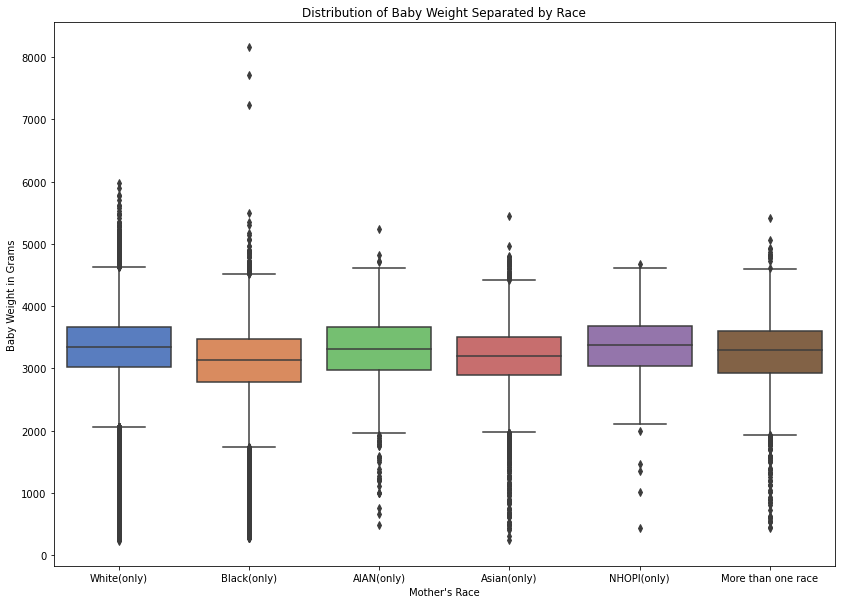

In [78]:
fig, ax = plt.subplots(figsize=(14,10))
sns.boxplot(x='MRAVE6',y='DBWT', data=df, palette='muted')
ax.set_title('Distribution of Baby Weight Separated by Race')
ax.set_xlabel('Mother\'s Race')
ax.set_ylabel('Baby Weight in Grams')
ax.set_xticklabels(['White(only)','Black(only)','AIAN(only)','Asian(only)','NHOPI(only)','More than one race']);

In [79]:
# null: Baby Weights of Moms of different Race are equal
# alt: Baby Weights of Moms of different Race are NOT equal
# alpha: 0.05
stats.f_oneway(_X[_X['MRAVE6_1'].eq(1)]['DBWT'],
              _X[_X['MRAVE6_2'].eq(1)]['DBWT'],
              _X[_X['MRAVE6_3'].eq(1)]['DBWT'],
              _X[_X['MRAVE6_4'].eq(1)]['DBWT'],
              _X[_X['MRAVE6_5'].eq(1)]['DBWT'],
              _X[_X['MRAVE6_6'].eq(1)]['DBWT'])

KeyError: 'DBWT'

In [ ]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison
_result = pairwise_tukeyhsd(df['DBWT'],df['MRAVE6'])
_result._results_table

In [ ]:
sns.distplot(df['pregnancy_length'],kde=False)

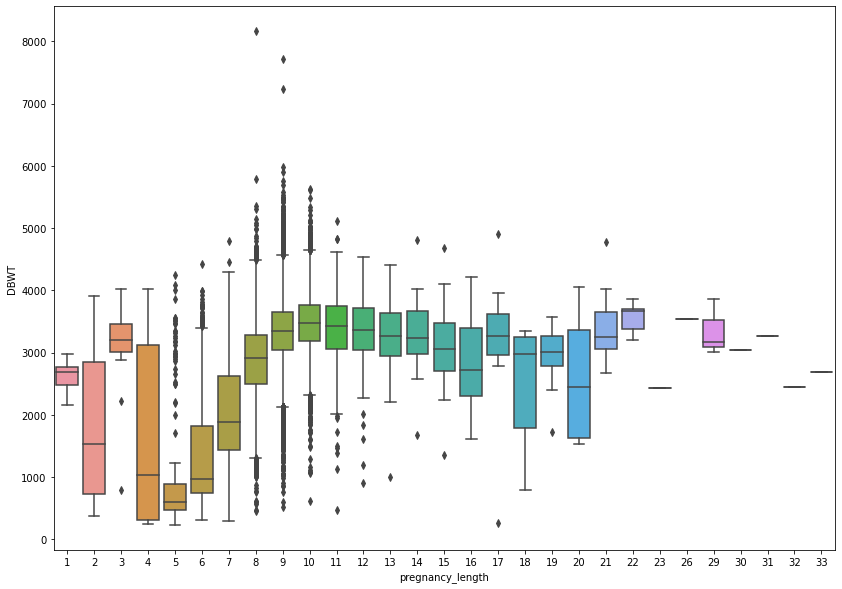

In [80]:
plt.figure(figsize=(14,10))
sns.boxplot(x='pregnancy_length',y='DBWT',data=df)

In [81]:
df[df['pregnancy_length'].lt(5)]

,ATTEND,BFACIL,BMI,CIG_0,DBWT,DLMP_MM,DLMP_YY,DMAR,DOB_MM,DOB_TT,DOB_WK,DOB_YY,DWgt_R,FAGECOMB,FEDUC,FHISPX,FRACE15,FRACE31,FRACE6,ILLB_R,ILOP_R,ILP_R,IMP_SEX,IP_GON,LD_INDL,MAGER,MAGE_IMPFLG,MAR_IMP,MBSTATE_REC,MEDUC,MHISPX,MM_AICU,MRACE15,MRACE31,MRACEIMP,MRAVE6,MTRAN,M_Ht_In,NO_INFEC,NO_MMORB,NO_RISKS,PAY,PAY_REC,PRECARE,PREVIS,PRIORDEAD,PRIORLIVE,PRIORTERM,PWgt_R,RDMETH_REC,RESTATUS,RF_CESAR,RF_CESARN,SEX,WTGAIN,binary_sex,first_birth,smoked,PRIORDEAD_cat,PRIORTERM_cat,PRIORLIVE_cat,pregnancy_length,MAGER_cat,pregnancy_length_cat,BMI_log,plural_delivery,first_pregnancy,first_natal,T35AGE_older,pregnancy_length_WTGAIN,MOM_weight,WTGAIN_div_MOM_weight,WTGAIN_div_length,Weight_before,WT_percent_gain
1835826,1,1,20.1,0,306,11,2017,2,3,1259,5,2018,175,29,9,0,2,2,2,888,888,888,,N,N,27,,1,1,4,0,N,2,2,,2,N,70,1,1,1,2,2,0,0,0,0,0,140,1,2,N,0,F,35,0,1,None,None,None,None,4,Adult,Early,3.000720,No,1,1,0,0.028571,139.900568,0.250178,8.750000,104.900568,0.250000
47045,1,1,32.2,0,3156,5,2018,2,9,359,2,2018,196,99,9,9,99,99,9,250,888,250,,N,N,40,,1,1,5,0,N,2,2,,2,N,63,1,1,1,1,1,6,8,0,1,0,182,1,1,N,0,M,14,1,0,None,None,None,Yes,4,Adult,Early,3.471966,No,0,1,1,0.021978,181.536648,0.077119,3.500000,167.536648,0.076923
3691882,1,1,18.3,0,624,11,2017,1,1,2245,5,2018,113,38,5,0,1,1,1,12,888,12,,N,N,32,,1,2,7,0,N,1,1,,1,N,65,1,1,0,2,2,5,6,0,2,0,110,1,1,N,0,F,3,0,0,None,None,None,Yes,2,Adult,Early,2.906901,No,0,1,0,0.018182,109.825994,0.027316,1.500000,106.825994,0.027273
434488,1,1,29.3,0,351,3,2018,0,7,2241,5,2018,207,39,9,9,99,99,9,888,888,888,,N,N,40,,1,1,9,9,N,2,2,1,2,N,67,1,1,1,1,1,2,6,0,0,0,187,1,1,N,0,F,20,0,1,None,None,None,None,4,Adult,Early,3.377588,No,1,1,1,0.021390,186.829119,0.107050,5.000000,166.829119,0.106952
2490944,1,1,31.5,0,280,12,2017,2,4,2213,2,2018,172,99,9,9,99,99,9,9,57,9,,N,N,22,,1,1,3,0,N,2,2,,2,N,62,1,1,0,1,1,0,0,0,2,3,172,1,1,N,0,F,0,0,0,None,None,Yes,Yes,4,Adult,Early,3.449988,No,0,0,0,0.023256,171.997159,0.000000,0.000000,171.997159,0.000000
2118586,1,1,36.2,0,3960,7,2018,1,11,849,5,2018,207,35,3,1,99,99,9,40,888,40,,N,N,30,,1,2,2,1,N,2,2,1,2,N,62,1,1,0,3,3,3,9,0,3,0,198,4,1,Y,1,M,9,1,0,None,None,None,Yes,4,Adult,Early,3.589059,No,0,1,0,0.020202,197.660227,0.045533,2.250000,188.660227,0.045455
3505579,1,1,31.4,0,369,8,2018,2,12,640,2,2018,166,99,9,9,99,99,9,888,888,888,,N,N,17,,1,1,9,0,N,1,1,,1,N,61,1,1,1,2,2,0,0,0,0,0,166,1,1,N,0,F,0,0,1,None,None,None,None,4,Minor,Early,3.446808,No,1,1,0,0.024096,165.965057,0.000000,0.000000,165.965057,0.000000
92865,5,4,20.4,6,1525,8,2018,2,10,1112,3,2018,140,99,9,9,99,99,9,45,888,45,,N,N,24,,1,1,3,0,N,1,1,,1,N,67,0,1,0,3,3,0,0,0,3,0,130,2,1,Y,1,M,10,1,0,Daily,None,None,Yes,2,Adult,Early,3.015535,No,0,1,0,0.015385,130.078977,0.076876,5.000000,120.078977,0.076923
2128091,1,1,18.8,10,3912,10,2018,2,12,338,2,2018,170,99,9,9,99,99,9,184,9,9,,N,N,36,,1,1,3,0,N,1,1,,1,N,71,1,1,1,1,1,6,6,0,3,4,135,1,2,N,0,M,35,1,0,Daily,None,Yes,Yes,2,Adult,Early,2.933857,No,0,0,1,0.014815,134.617614,0.259996,17.500000,99.617614,0.259259
1088876,1,1,24.9,0,2510,6,2018,2,10,2021,5,2018,169,21,3,0,2,2,2,888,888,888,,N,N,18,,1,1,4,0,N,2,2,,2,N,62,1,1,1,1,1,7,6,0,0,0,136,1,2,N,0,M,33,1,1,None,None,None,None,4,Adult,Early,3.214868,No,1,1,0,0.029412,135.959659,0.242719,8.250000,102.959659,0.242647


In [82]:
_X.shape

(92717, 182)

In [83]:
_X['pregnancy_length_sqrt'] =  np.sqrt(_X['pregnancy_length'])
_X_columns = _X.columns

In [84]:
_X.describe()

,first_birth,first_pregnancy,first_natal,MAGER,pregnancy_length,WTGAIN_div_MOM_weight,WTGAIN_div_length,PRECARE,PREVIS,PWgt_R,BMI_log,M_Ht_In,MOM_weight,WTGAIN,WT_percent_gain,BMI,ATTEND_1,ATTEND_2,ATTEND_3,ATTEND_4,ATTEND_5,ATTEND_9,BFACIL_1,BFACIL_2,BFACIL_3,BFACIL_4,BFACIL_5,BFACIL_6,BFACIL_7,BFACIL_9,smoked_Daily,smoked_None,smoked_Unknown,DOB_MM_1,DOB_MM_2,DOB_MM_3,DOB_MM_4,DOB_MM_5,DOB_MM_6,DOB_MM_7,DOB_MM_8,DOB_MM_9,DOB_MM_10,DOB_MM_11,DOB_MM_12,DMAR_0,DMAR_1,DMAR_2,FHISPX_0,FHISPX_1,FHISPX_2,FHISPX_3,FHISPX_4,FHISPX_5,FHISPX_6,FHISPX_9,FEDUC_1,FEDUC_2,FEDUC_3,FEDUC_4,FEDUC_5,FEDUC_6,FEDUC_7,FEDUC_8,FEDUC_9,FRACE6_1,FRACE6_2,FRACE6_3,FRACE6_4,FRACE6_5,FRACE6_6,FRACE6_9,plural_delivery_No,plural_delivery_Yes,IP_GON_N,IP_GON_U,IP_GON_Y,LD_INDL_N,LD_INDL_U,LD_INDL_Y,T35AGE_older_0,T35AGE_older_1,MAR_IMP_1,MBSTATE_REC_1,MBSTATE_REC_2,MBSTATE_REC_3,MEDUC_1,MEDUC_2,MEDUC_3,MEDUC_4,MEDUC_5,MEDUC_6,MEDUC_7,MEDUC_8,MEDUC_9,MHISPX_0,MHISPX_1,MHISPX_2,MHISPX_3,MHISPX_4,MHISPX_5,MHISPX_6,MHISPX_9,MRAVE6_1,MRAVE6_2,MRAVE6_3,MRAVE6_4,MRAVE6_5,MRAVE6_6,MTRAN_N,MTRAN_U,MTRAN_Y,NO_INFEC_0,NO_INFEC_1,NO_INFEC_9,NO_MMORB_0,NO_MMORB_1,NO_MMORB_9,NO_RISKS_0,NO_RISKS_1,NO_RISKS_9,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,PAY_8,PAY_9,PAY_REC_1,PAY_REC_2,PAY_REC_3,PAY_REC_4,PAY_REC_9,PRIORDEAD_cat_None,PRIORDEAD_cat_Unknown,PRIORDEAD_cat_Yes,PRIORLIVE_cat_None,PRIORLIVE_cat_Unknown,PRIORLIVE_cat_Yes,PRIORTERM_cat_None,PRIORTERM_cat_Unknown,PRIORTERM_cat_Yes,RDMETH_REC_1,RDMETH_REC_2,RDMETH_REC_3,RDMETH_REC_4,RDMETH_REC_5,RDMETH_REC_6,RDMETH_REC_9,RESTATUS_1,RESTATUS_2,RESTATUS_3,RESTATUS_4,RF_CESAR_N,RF_CESAR_U,RF_CESAR_Y,SEX_F,SEX_M,MAGER_cat_Adult,MAGER_cat_Minor,pregnancy_length_cat_10,pregnancy_length_cat_8,pregnancy_length_cat_9,pregnancy_length_cat_Early,pregnancy_length_cat_Late,MAGER_smoked_Daily,NO_RISKS_1_length,RDMETH_REC_3_length,RDMETH_REC_1_length,ATTEND_1_length,MRAVE6_1_FRACE6_1,BFACIL_1_length,BMI_log_length,M_Ht_In_length,LD_INDL_N_length,MTRAN_Y_length,PRECARE_length,PREVIS_length,MOM_weight_length,RDMETH_REC_3_pregnancy_length_cat_9,RF_CESAR_Y_pregnancy_length_cat_9,pregnancy_length_sqrt
count,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.00000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.00000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.00000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.0,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.00000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000

In [85]:
categorical_columns = []
continuous_columns = []
for i in _X_columns:
    if _X[i].max() == 1:
        categorical_columns.append(i)
    else:
        continuous_columns.append(i)

In [86]:
continuous_columns

['MAGER',
 'pregnancy_length',
 'WTGAIN_div_MOM_weight',
 'WTGAIN_div_length',
 'PRECARE',
 'PREVIS',
 'PWgt_R',
 'BMI_log',
 'M_Ht_In',
 'MOM_weight',
 'WTGAIN',
 'WT_percent_gain',
 'BMI',
 'MAGER_smoked_Daily',
 'NO_RISKS_1_length',
 'RDMETH_REC_3_length',
 'RDMETH_REC_1_length',
 'ATTEND_1_length',
 'BFACIL_1_length',
 'BMI_log_length',
 'M_Ht_In_length',
 'LD_INDL_N_length',
 'MTRAN_Y_length',
 'PRECARE_length',
 'PREVIS_length',
 'MOM_weight_length',
 'pregnancy_length_sqrt']

In [87]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
_X[continuous_columns] = scaler.fit_transform(_X[continuous_columns])
_X = pd.DataFrame(data=_X, columns = _X_columns)

In [88]:
list(_X.columns)

['first_birth',
 'first_pregnancy',
 'first_natal',
 'MAGER',
 'pregnancy_length',
 'WTGAIN_div_MOM_weight',
 'WTGAIN_div_length',
 'PRECARE',
 'PREVIS',
 'PWgt_R',
 'BMI_log',
 'M_Ht_In',
 'MOM_weight',
 'WTGAIN',
 'WT_percent_gain',
 'BMI',
 'ATTEND_1',
 'ATTEND_2',
 'ATTEND_3',
 'ATTEND_4',
 'ATTEND_5',
 'ATTEND_9',
 'BFACIL_1',
 'BFACIL_2',
 'BFACIL_3',
 'BFACIL_4',
 'BFACIL_5',
 'BFACIL_6',
 'BFACIL_7',
 'BFACIL_9',
 'smoked_Daily',
 'smoked_None',
 'smoked_Unknown',
 'DOB_MM_1',
 'DOB_MM_2',
 'DOB_MM_3',
 'DOB_MM_4',
 'DOB_MM_5',
 'DOB_MM_6',
 'DOB_MM_7',
 'DOB_MM_8',
 'DOB_MM_9',
 'DOB_MM_10',
 'DOB_MM_11',
 'DOB_MM_12',
 'DMAR_0',
 'DMAR_1',
 'DMAR_2',
 'FHISPX_0',
 'FHISPX_1',
 'FHISPX_2',
 'FHISPX_3',
 'FHISPX_4',
 'FHISPX_5',
 'FHISPX_6',
 'FHISPX_9',
 'FEDUC_1',
 'FEDUC_2',
 'FEDUC_3',
 'FEDUC_4',
 'FEDUC_5',
 'FEDUC_6',
 'FEDUC_7',
 'FEDUC_8',
 'FEDUC_9',
 'FRACE6_1',
 'FRACE6_2',
 'FRACE6_3',
 'FRACE6_4',
 'FRACE6_5',
 'FRACE6_6',
 'FRACE6_9',
 'plural_delivery_No',
 'plu

In [89]:
_X.describe()

,first_birth,first_pregnancy,first_natal,MAGER,pregnancy_length,WTGAIN_div_MOM_weight,WTGAIN_div_length,PRECARE,PREVIS,PWgt_R,BMI_log,M_Ht_In,MOM_weight,WTGAIN,WT_percent_gain,BMI,ATTEND_1,ATTEND_2,ATTEND_3,ATTEND_4,ATTEND_5,ATTEND_9,BFACIL_1,BFACIL_2,BFACIL_3,BFACIL_4,BFACIL_5,BFACIL_6,BFACIL_7,BFACIL_9,smoked_Daily,smoked_None,smoked_Unknown,DOB_MM_1,DOB_MM_2,DOB_MM_3,DOB_MM_4,DOB_MM_5,DOB_MM_6,DOB_MM_7,DOB_MM_8,DOB_MM_9,DOB_MM_10,DOB_MM_11,DOB_MM_12,DMAR_0,DMAR_1,DMAR_2,FHISPX_0,FHISPX_1,FHISPX_2,FHISPX_3,FHISPX_4,FHISPX_5,FHISPX_6,FHISPX_9,FEDUC_1,FEDUC_2,FEDUC_3,FEDUC_4,FEDUC_5,FEDUC_6,FEDUC_7,FEDUC_8,FEDUC_9,FRACE6_1,FRACE6_2,FRACE6_3,FRACE6_4,FRACE6_5,FRACE6_6,FRACE6_9,plural_delivery_No,plural_delivery_Yes,IP_GON_N,IP_GON_U,IP_GON_Y,LD_INDL_N,LD_INDL_U,LD_INDL_Y,T35AGE_older_0,T35AGE_older_1,MAR_IMP_1,MBSTATE_REC_1,MBSTATE_REC_2,MBSTATE_REC_3,MEDUC_1,MEDUC_2,MEDUC_3,MEDUC_4,MEDUC_5,MEDUC_6,MEDUC_7,MEDUC_8,MEDUC_9,MHISPX_0,MHISPX_1,MHISPX_2,MHISPX_3,MHISPX_4,MHISPX_5,MHISPX_6,MHISPX_9,MRAVE6_1,MRAVE6_2,MRAVE6_3,MRAVE6_4,MRAVE6_5,MRAVE6_6,MTRAN_N,MTRAN_U,MTRAN_Y,NO_INFEC_0,NO_INFEC_1,NO_INFEC_9,NO_MMORB_0,NO_MMORB_1,NO_MMORB_9,NO_RISKS_0,NO_RISKS_1,NO_RISKS_9,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,PAY_8,PAY_9,PAY_REC_1,PAY_REC_2,PAY_REC_3,PAY_REC_4,PAY_REC_9,PRIORDEAD_cat_None,PRIORDEAD_cat_Unknown,PRIORDEAD_cat_Yes,PRIORLIVE_cat_None,PRIORLIVE_cat_Unknown,PRIORLIVE_cat_Yes,PRIORTERM_cat_None,PRIORTERM_cat_Unknown,PRIORTERM_cat_Yes,RDMETH_REC_1,RDMETH_REC_2,RDMETH_REC_3,RDMETH_REC_4,RDMETH_REC_5,RDMETH_REC_6,RDMETH_REC_9,RESTATUS_1,RESTATUS_2,RESTATUS_3,RESTATUS_4,RF_CESAR_N,RF_CESAR_U,RF_CESAR_Y,SEX_F,SEX_M,MAGER_cat_Adult,MAGER_cat_Minor,pregnancy_length_cat_10,pregnancy_length_cat_8,pregnancy_length_cat_9,pregnancy_length_cat_Early,pregnancy_length_cat_Late,MAGER_smoked_Daily,NO_RISKS_1_length,RDMETH_REC_3_length,RDMETH_REC_1_length,ATTEND_1_length,MRAVE6_1_FRACE6_1,BFACIL_1_length,BMI_log_length,M_Ht_In_length,LD_INDL_N_length,MTRAN_Y_length,PRECARE_length,PREVIS_length,MOM_weight_length,RDMETH_REC_3_pregnancy_length_cat_9,RF_CESAR_Y_pregnancy_length_cat_9,pregnancy_length_sqrt
count,92717.000000,92717.000000,92717.000000,9.271700e+04,9.271700e+04,9.271700e+04,9.271700e+04,9.271700e+04,9.271700e+04,9.271700e+04,9.271700e+04,9.271700e+04,9.271700e+04,9.271700e+04,9.271700e+04,9.271700e+04,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.00000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.00000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.0,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.00000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.000000,92717.00

In [90]:
ols_columns = [
    #categorical
    'SEX_M',
    'BFACIL_1',
    'ATTEND_1',
    'FRACE6_1',
    'FRACE6_9',
    'FRACE6_2',
    'FEDUC_3',
    'first_birth',
    'plural_delivery_No',
    'LD_INDL_N',
    'LD_INDL_N',
    'MBSTATE_REC_1',
    'MEDUC_6',
    'MEDUC_3',
    'MEDUC_4',
    'MHISPX_0',
    'MHISPX_1',
    'MRAVE6_1',
    'MRAVE6_2',
    'MTRAN_N',
    'NO_RISKS_1',
    'PAY_1',
    'PRIORDEAD_cat_None',
    'RDMETH_REC_3',
    'RDMETH_REC_1',
    'RDMETH_REC_4',
    'RF_CESAR_N',
    'pregnancy_length_cat_9',
    'pregnancy_length_cat_8',
    'pregnancy_length_cat_10',
    'pregnancy_length_cat_Early',
    #continuous
    'BMI_log',
    'WTGAIN',
    'M_Ht_In',
    'PRECARE',
    'PREVIS',
    'MOM_weight',
    'pregnancy_length_sqrt',
    #combo
    'MAGER_smoked_Daily',
    'WTGAIN_div_MOM_weight',
    'WTGAIN_div_length',
    'NO_RISKS_1_length',
    'RDMETH_REC_3_length',
    'RDMETH_REC_1_length',
    'ATTEND_1_length',
    'BFACIL_1_length',
    'BMI_log_length',
    'M_Ht_In_length',
    'LD_INDL_N_length',
    'LD_INDL_N_length',
    'MTRAN_Y_length',
    'NO_RISKS_1_length',
    'PREVIS_length',
    'MOM_weight_length',
    'RDMETH_REC_3_pregnancy_length_cat_9',
    'RF_CESAR_Y_pregnancy_length_cat_9',
    
]

In [91]:
list(_X_columns)

['first_birth',
 'first_pregnancy',
 'first_natal',
 'MAGER',
 'pregnancy_length',
 'WTGAIN_div_MOM_weight',
 'WTGAIN_div_length',
 'PRECARE',
 'PREVIS',
 'PWgt_R',
 'BMI_log',
 'M_Ht_In',
 'MOM_weight',
 'WTGAIN',
 'WT_percent_gain',
 'BMI',
 'ATTEND_1',
 'ATTEND_2',
 'ATTEND_3',
 'ATTEND_4',
 'ATTEND_5',
 'ATTEND_9',
 'BFACIL_1',
 'BFACIL_2',
 'BFACIL_3',
 'BFACIL_4',
 'BFACIL_5',
 'BFACIL_6',
 'BFACIL_7',
 'BFACIL_9',
 'smoked_Daily',
 'smoked_None',
 'smoked_Unknown',
 'DOB_MM_1',
 'DOB_MM_2',
 'DOB_MM_3',
 'DOB_MM_4',
 'DOB_MM_5',
 'DOB_MM_6',
 'DOB_MM_7',
 'DOB_MM_8',
 'DOB_MM_9',
 'DOB_MM_10',
 'DOB_MM_11',
 'DOB_MM_12',
 'DMAR_0',
 'DMAR_1',
 'DMAR_2',
 'FHISPX_0',
 'FHISPX_1',
 'FHISPX_2',
 'FHISPX_3',
 'FHISPX_4',
 'FHISPX_5',
 'FHISPX_6',
 'FHISPX_9',
 'FEDUC_1',
 'FEDUC_2',
 'FEDUC_3',
 'FEDUC_4',
 'FEDUC_5',
 'FEDUC_6',
 'FEDUC_7',
 'FEDUC_8',
 'FEDUC_9',
 'FRACE6_1',
 'FRACE6_2',
 'FRACE6_3',
 'FRACE6_4',
 'FRACE6_5',
 'FRACE6_6',
 'FRACE6_9',
 'plural_delivery_No',
 'plu

In [215]:
_new_columns = [
#     'first_birth',
#  'first_pregnancy',
#  'first_natal',
 'MAGER',
#  'pregnancy_length',
#  'WTGAIN_div_MOM_weight',
 'WTGAIN_div_length',
 'PRECARE',
 'PREVIS',
#  'PWgt_R',
 'BMI_log',
 'M_Ht_In',
 'MOM_weight',
 'WTGAIN',
 'WT_percent_gain',
#  'BMI',
 'ATTEND_1',
#  'ATTEND_2',
 'ATTEND_3',
 'ATTEND_4',
#  'ATTEND_5',
#  'ATTEND_9',
#  'BFACIL_1',
 'BFACIL_2',
 'BFACIL_3',
#  'BFACIL_4',
 'BFACIL_5',
#  'BFACIL_6',
#  'BFACIL_7',
#  'BFACIL_9',
#  'smoked_Daily',
 'smoked_None',
#  'smoked_Unknown',
#  'DOB_MM_1',
#  'DOB_MM_2',
#  'DOB_MM_3',
#  'DOB_MM_4',
#  'DOB_MM_5',
#  'DOB_MM_6',
#  'DOB_MM_7',
#  'DOB_MM_8',
#  'DOB_MM_9',
#  'DOB_MM_10',
#  'DOB_MM_11',
#  'DOB_MM_12',
#  'DMAR_0',
#  'DMAR_1',
 'DMAR_2',
 'FHISPX_0',
#  'FHISPX_1',
#  'FHISPX_2',
#  'FHISPX_3',
#  'FHISPX_4',
#  'FHISPX_5',
#  'FHISPX_6',
#  'FHISPX_9',
#  'FEDUC_1',
#  'FEDUC_2',
#  'FEDUC_3',
#  'FEDUC_4',
#  'FEDUC_5',
 'FEDUC_6',
#  'FEDUC_7',
 'FEDUC_8',
#  'FEDUC_9',
 'FRACE6_1',
#  'FRACE6_2',
#  'FRACE6_3',
 'FRACE6_4',
#  'FRACE6_5',
#  'FRACE6_6',
#  'FRACE6_9',
#  'plural_delivery_No',
 'plural_delivery_Yes',
#  'IP_GON_N',
#  'IP_GON_U',
#  'IP_GON_Y',
 'LD_INDL_N',
#  'LD_INDL_U',
#  'LD_INDL_Y',
#  'T35AGE_older_0',
 'T35AGE_older_1',
#  'MAR_IMP_1',
 'MBSTATE_REC_1',
#  'MBSTATE_REC_2',
#  'MBSTATE_REC_3',
 'MEDUC_1',
#  'MEDUC_2',
 'MEDUC_3',
 'MEDUC_4',
 'MEDUC_5',
 'MEDUC_6',
 'MEDUC_7',
#  'MEDUC_8',
#  'MEDUC_9',
 'MHISPX_0',
#  'MHISPX_1',
 'MHISPX_2',
#  'MHISPX_3',
#  'MHISPX_4',
#  'MHISPX_5',
 'MHISPX_6',
#  'MHISPX_9',
#  'MRAVE6_1',
 'MRAVE6_2',
#  'MRAVE6_3',
 'MRAVE6_4',
#  'MRAVE6_5',
 'MRAVE6_6',
#  'MTRAN_N',
#  'MTRAN_U',
 'MTRAN_Y',
 'NO_INFEC_0',
#  'NO_INFEC_1',
#  'NO_INFEC_9',
 'NO_MMORB_0',
#  'NO_MMORB_1',
#  'NO_MMORB_9',
 'NO_RISKS_0',
#  'NO_RISKS_1',
#  'NO_RISKS_9',
#  'PAY_1',
#  'PAY_2',
#  'PAY_3',
#  'PAY_4',
#  'PAY_5',
#  'PAY_6',
 'PAY_8',
#  'PAY_9',
 'PAY_REC_1',
#  'PAY_REC_2',
#  'PAY_REC_3',
#  'PAY_REC_4',
#  'PAY_REC_9',
#  'PRIORDEAD_cat_None',
#  'PRIORDEAD_cat_Unknown',
 'PRIORDEAD_cat_Yes',
#  'PRIORLIVE_cat_None',
#  'PRIORLIVE_cat_Unknown',
 'PRIORLIVE_cat_Yes',
#  'PRIORTERM_cat_None',
#  'PRIORTERM_cat_Unknown',
#  'PRIORTERM_cat_Yes',
#  'RDMETH_REC_1',
#  'RDMETH_REC_2',
 'RDMETH_REC_3',
#  'RDMETH_REC_4',
#  'RDMETH_REC_5',
#  'RDMETH_REC_6',
#  'RDMETH_REC_9',
 'RESTATUS_1',
#  'RESTATUS_2',
#  'RESTATUS_3',
#  'RESTATUS_4',
 'RF_CESAR_N',
#  'RF_CESAR_U',
#  'RF_CESAR_Y',
#  'SEX_F',
 'SEX_M',
#  'MAGER_cat_Adult',
 'MAGER_cat_Minor',
 'pregnancy_length_cat_10',
 'pregnancy_length_cat_8',
 'pregnancy_length_cat_9',
 'pregnancy_length_cat_Early',
#  'pregnancy_length_cat_Late',
 'MAGER_smoked_Daily',
 'NO_RISKS_1_length',
 'RDMETH_REC_3_length',
 'RDMETH_REC_1_length',
 'ATTEND_1_length',
 'MRAVE6_1_FRACE6_1',
 'BFACIL_1_length',
 'BMI_log_length',
#  'M_Ht_In_length',
 'LD_INDL_N_length',
 'MTRAN_Y_length',
 'PRECARE_length',
 'PREVIS_length',
 'MOM_weight_length',
 'RDMETH_REC_3_pregnancy_length_cat_9',
 'RF_CESAR_Y_pregnancy_length_cat_9',
 'pregnancy_length_sqrt']

In [216]:

_X['DBWT'] = y
from statsmodels.formula.api import ols
formula = 'DBWT~'+'+'.join(_new_columns)
model = ols(formula=formula, data=_X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   DBWT   R-squared:                       0.374
Model:                            OLS   Adj. R-squared:                  0.373
Method:                 Least Squares   F-statistic:                     778.8
Date:                Thu, 30 Jul 2020   Prob (F-statistic):               0.00
Time:                        13:54:57   Log-Likelihood:            -7.0039e+05
No. Observations:               92717   AIC:                         1.401e+06
Df Residuals:                   92645   BIC:                         1.402e+06
Df Model:                          71                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                            2915.7824     80.298     36.312      0.000    2758.400    3073.165
MAGER                                  -7.5373      2.611     -2.886      0.004     -12.656      -2.419
WTGAIN_div_length                     192.7354     12.066     15.973      0.000     169.086     216.385
PRECARE                               320.0642     15.852     20.191      0.000     288.995     351.134
PREVIS                                161.1348     16.448      9.797      0.000     128.897     193.373
BMI_log                               372.3792     22.229     16.752      0.000     328.810     415.949
M_Ht_In                               140.8504      4.533     31.074      0.000     131.966     149.735
MOM_weight                           -332.4092     28.342    -11.729      0.000    -387.959    -276.860
WTGAIN                               -186.5461     13.648    -13.669      0.000    -213.295    -159.797
WT_percent_gain                       111.3166      7.777     14.313      0.000      96.073     126.560
ATTEND_1                             -144.4157     45.490     -3.175      0.002    -233.575     -55.257
ATTEND_3                               55.0303      7.235      7.606      0.000      40.850      69.211
ATTEND_4                               68.6456     22.051      3.113      0.002      25.425     111.866
BFACIL_2                              159.9244     40.892      3.911      0.000      79.776     240.073
BFACIL_3                              215.9181     39.913      5.410      0.000     137.689     294.147
BFACIL_5                              139.8933     58.263      2.401      0.016      25.697     254.089
smoked_None                            54.5213     19.489      2.798      0.005      16.323      92.719
DMAR_2                                -14.5203      4.008     -3.623      0.000     -22.375      -6.665
FHISPX_0                               37.1622      4.519      8.224      0.000      28.305      46.019
FEDUC_6                                14.8894      4.589      3.244      0.001       5.894      23.885
FEDUC_8                                21.8420      9.421      2.318      0.020       3.376      40.308
FRACE6_1                               59.5075     10.573      5.628      0.000      38.784      80.231
FRACE6_4                              -80.4769     11.868     -6.781      0.000    -103.738     -57.216
plural_delivery_Yes                  -688.4028     13.865    -49.651      0.000    -715.578    -661.228
LD_INDL_N                            -111.6040     43.151     -2.586      0.010    -196.179     -27.029
T35AGE_older_1                        -16.3397      5.594     -2.921      0.003     -27.304      -5.375
MBSTATE_REC_1                         -56.4331      4.520    -12.48

In [214]:
_new_columns

['MAGER',
 'WTGAIN_div_length',
 'PRECARE',
 'PREVIS',
 'BMI_log',
 'M_Ht_In',
 'MOM_weight',
 'WTGAIN',
 'WT_percent_gain',
 'BMI',
 'ATTEND_1',
 'ATTEND_3',
 'ATTEND_4',
 'BFACIL_2',
 'BFACIL_3',
 'BFACIL_5',
 'smoked_None',
 'DMAR_2',
 'FHISPX_0',
 'FEDUC_6',
 'FEDUC_8',
 'FRACE6_1',
 'FRACE6_4',
 'plural_delivery_Yes',
 'LD_INDL_N',
 'T35AGE_older_1',
 'MBSTATE_REC_1',
 'MEDUC_1',
 'MEDUC_3',
 'MEDUC_4',
 'MEDUC_5',
 'MEDUC_6',
 'MEDUC_7',
 'MHISPX_0',
 'MHISPX_2',
 'MHISPX_6',
 'MRAVE6_2',
 'MRAVE6_4',
 'MRAVE6_6',
 'MTRAN_Y',
 'NO_INFEC_0',
 'NO_MMORB_0',
 'NO_RISKS_0',
 'PAY_8',
 'PAY_REC_1',
 'PRIORDEAD_cat_Yes',
 'PRIORLIVE_cat_Yes',
 'RDMETH_REC_3',
 'RESTATUS_1',
 'RF_CESAR_N',
 'SEX_M',
 'MAGER_cat_Minor',
 'pregnancy_length_cat_10',
 'pregnancy_length_cat_8',
 'pregnancy_length_cat_9',
 'pregnancy_length_cat_Early',
 'MAGER_smoked_Daily',
 'NO_RISKS_1_length',
 'RDMETH_REC_3_length',
 'RDMETH_REC_1_length',
 'ATTEND_1_length',
 'MRAVE6_1_FRACE6_1',
 'BFACIL_1_length',
 'BM